## Extracting and Loading X-Ray Data

/var/folders/md/qxkcfv650bx_kd_5hlgqrct40000gn/T/ipykernel_4528/3396236357.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Using previously extracted files...
Loading dataset from ./data/NIH/extracted/images-224
Dataset size: 28868

Available pathologies:
1. Atelectasis
2. Cardiomegaly
3. Consolidation
4. Edema
5. Effusion
6. Emphysema
7. Fibrosis
8. Hernia
9. Infiltration
10. Mass
11. Nodule
12. Pleural_Thickening
13. Pneumonia
14. Pneumothorax

Pathology counts:
Atelectasis:
  Present: 1557
  Absent: 27311
  Percentage: 5.39%

Cardiomegaly:
  Present: 729
  Absent: 28139
  Percentage: 2.53%

Consolidation:
  Present: 384
  Absent: 28484
  Percentage: 1.33%

Edema:
  Present: 39
  Absent: 28829
  Percentage: 0.14%

Effusion:
  Present: 1269
  Absent: 27599
  Percentage: 4.40%

Emphysema:
  Present: 264
  Absent: 28604
  Percentage: 0.91%

Fibrosis:
  Present: 556
  Absent: 28312
  Percentage: 1.93%

Hernia:
  Present: 81
  Absent: 28787
  Percentage: 0.28%

Infiltration:
  Present: 3273
  Absent: 25595
  Percentage: 11.34%

Mass:
  Present: 1213
  Absent: 27655
  Percentage: 4.20%

Nodule:
  Present: 1609

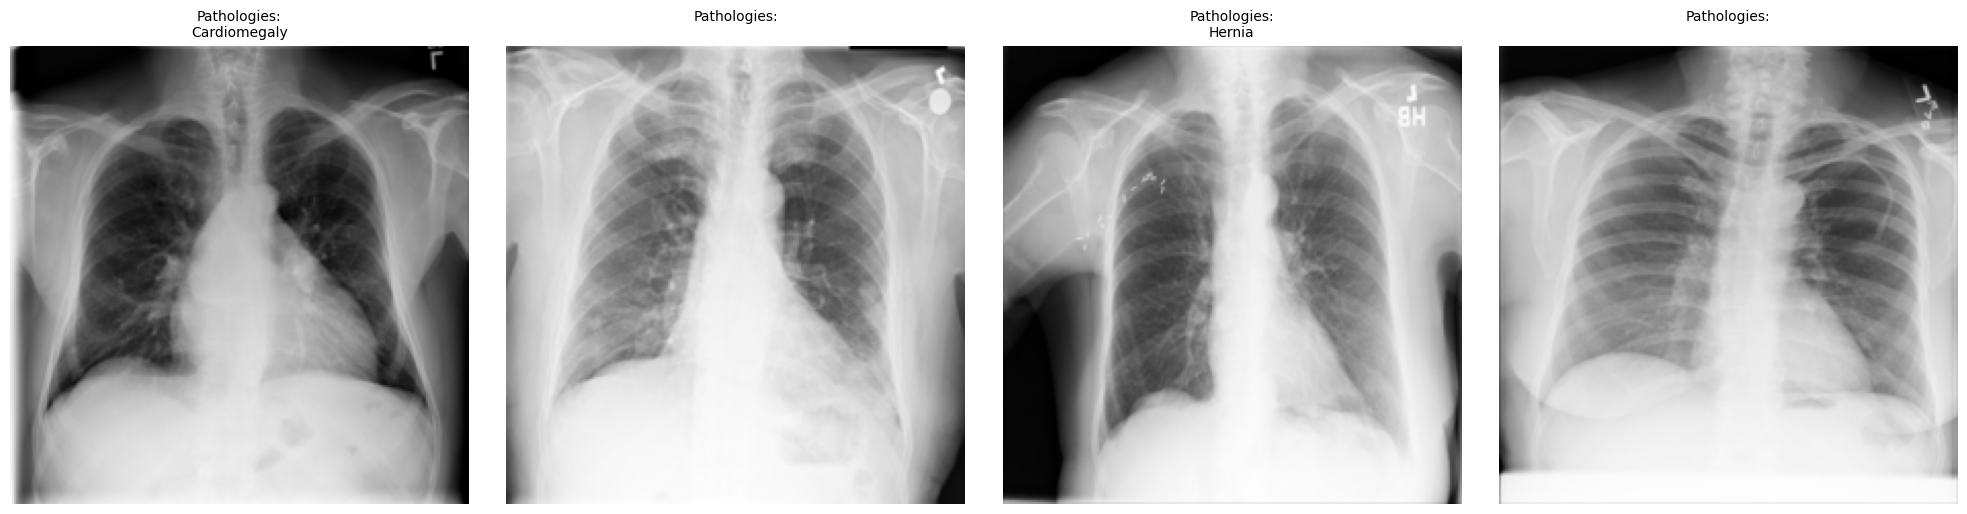

In [1]:
from tqdm.autonotebook import tqdm
from vincent_util import (
    load_nih_dataset,
    print_dataset_info,
    show_sample_images,
    )

imgpath = "./data/NIH/images-224.tar"

# Load dataset
dataset, dataloader = load_nih_dataset(
    imgpath=imgpath,
    extract_dir="./data/NIH/extracted",
    views=['PA'],
    unique_patients=True
)

# Print dataset information
print_dataset_info(dataset)

# Show sample images
show_sample_images(dataset)

## Loading Pre-trained Dense Net Model

In [2]:
import torchxrayvision as xrv

model = xrv.models.DenseNet(weights="densenet121-res224-nih")

## Running Base Inference Pipeline with Model

Dataset structure:
Using subset dataset
Original dataset type: <class 'torchxrayvision.datasets.NIH_Dataset'>

Number of pathologies: 14
Pathologies: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

Batch information:
Batch type: <class 'dict'>
Batch keys: dict_keys(['idx', 'lab', 'img'])
Images shape: torch.Size([4, 1, 224, 224])
Labels shape: torch.Size([4, 14])

Predictions shape: torch.Size([4, 18])

Debug - Prediction vector length: 18
Debug - Number of pathologies: 14
Debug - Model pathologies: ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', '', '', '', '']

Debug - Prediction vector length: 18
Debug - Number of pathologies: 14
Debug - Model pathologies: ['Atelectasis', 'Consolidation', 'Infiltration'

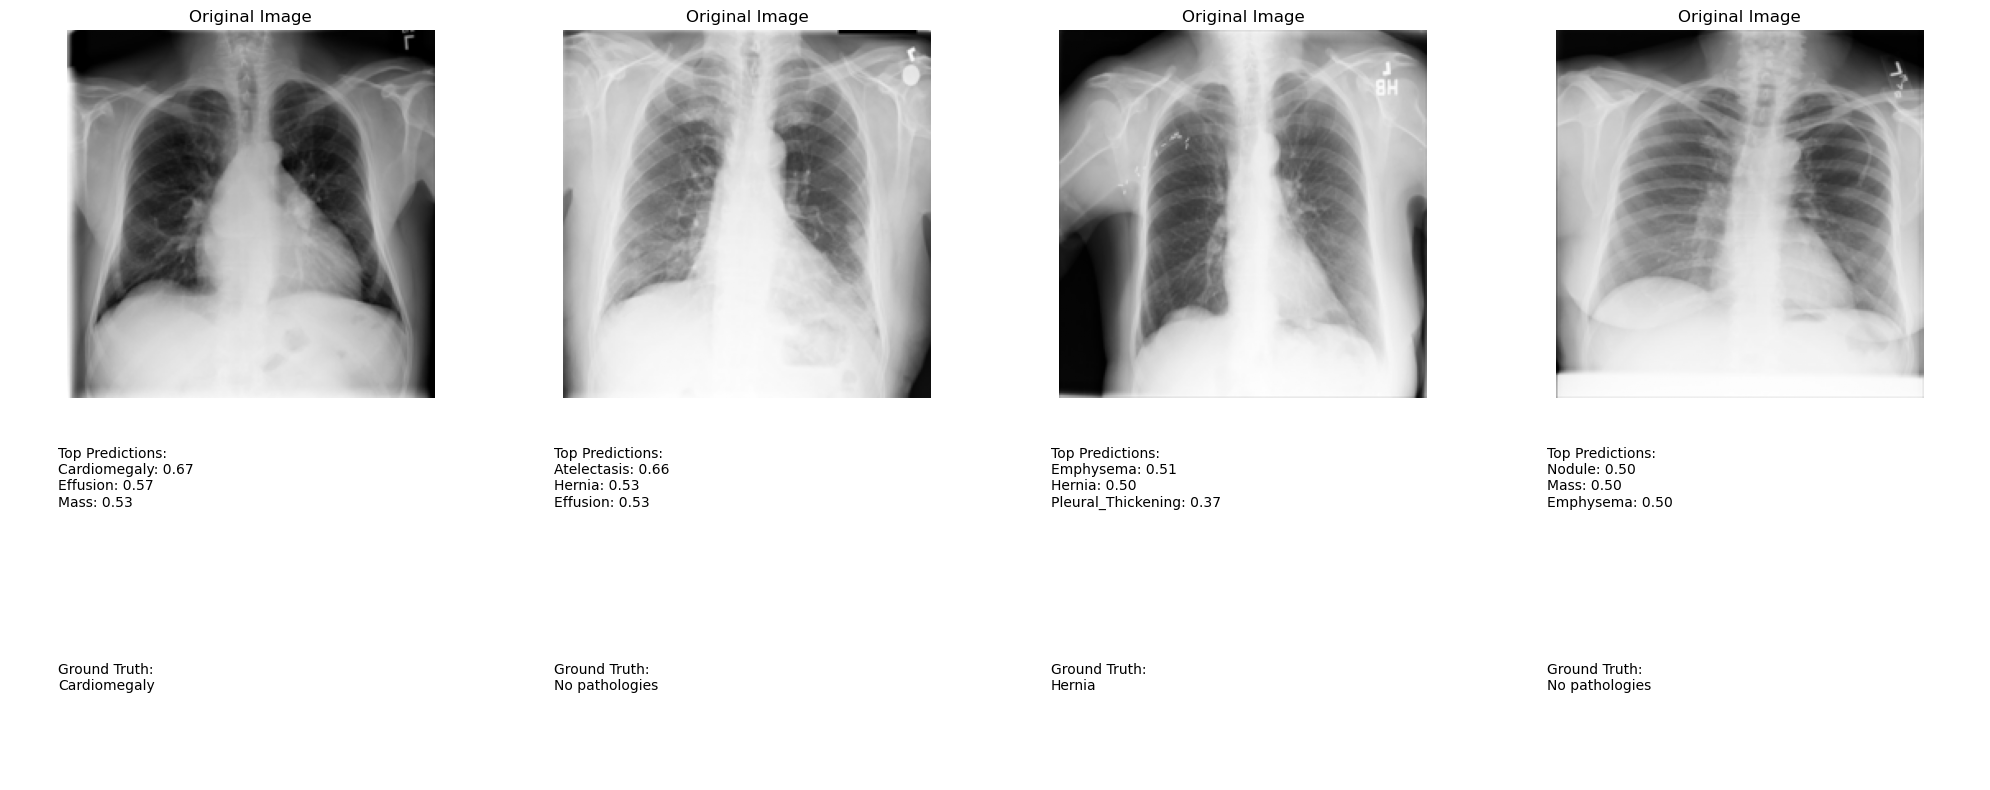

In [3]:
import torch
from torch.utils.data import DataLoader
from vincent_util import run_inference

# Create a small subset for testing
small_subset = torch.utils.data.Subset(dataset, indices=range(4))
test_loader = DataLoader(small_subset, batch_size=4)

# Run inference
preds = run_inference(model, test_loader, num_samples=4)

## Taking subset and splitting into train and test

In [4]:
train_dataset = torch.utils.data.Subset(dataset, indices=range(10000))
train_loader = DataLoader(train_dataset, batch_size=4)

test_dataset = torch.utils.data.Subset(dataset, indices=range(1000, 1500))
test_loader = DataLoader(test_dataset, batch_size=4)

## Bayesian Estimator

In [5]:
from vincent_util import (
    extract_features,
    reduce_dimensions,
    discretize_features,
    construct_bayesian_network_with_uncertainty,
    simplified_inference_test
)

print("Extracting features...")
#features, labels = extract_features(model, train_loader)
features, labels = extract_features(model, dataloader)

print("Reducing Dimensionality...")
reduced_features, reducer, scaler = reduce_dimensions(
    features, 
    n_components=25
)

print("Discretizing features...")
discretized_features, bin_edges = discretize_features(reduced_features)

Extracting features...


Extracting features:   0%|          | 0/903 [00:00<?, ?it/s]

Reducing Dimensionality...
PCA with 25 components explains 95.08% of variance
Discretizing features...


In [6]:
pathologies = dataset.pathologies
print("Constructing Bayesian network with parameter uncertainty...")
bayes_net, param_samples, data, feature_cols, pathology_cols = construct_bayesian_network_with_uncertainty(
    discretized_features, 
    labels,
    pathologies
)

Constructing Bayesian network with parameter uncertainty...
Performing Bayesian parameter estimation...


Sampling parameters:   0%|          | 0/39 [00:00<?, ?it/s]


Processing sample 0 with features: {'f0': 5, 'f1': 4, 'f2': 3, 'f3': 3, 'f4': 3, 'f5': 3, 'f6': 3, 'f7': 4, 'f8': 3, 'f9': 3, 'f10': 3, 'f11': 2, 'f12': 4, 'f13': 2, 'f14': 4, 'f15': 2, 'f16': 5, 'f17': 2, 'f18': 3, 'f19': 2, 'f20': 2, 'f21': 3, 'f22': 4, 'f23': 4, 'f24': 3}
Ground truth: {'Atelectasis': 0, 'Cardiomegaly': 0, 'Consolidation': 0, 'Edema': 0, 'Effusion': 0, 'Emphysema': 0, 'Fibrosis': 0, 'Hernia': 0, 'Infiltration': 0, 'Mass': 0, 'Nodule': 0, 'Pleural_Thickening': 0, 'Pneumonia': 0, 'Pneumothorax': 0}
Traditional inference results:
  Atelectasis: 0.0238 (Ground truth: 0)
  Cardiomegaly: 0.0061 (Ground truth: 0)
  Consolidation: 0.0010 (Ground truth: 0)
  Edema: 0.0000 (Ground truth: 0)
  Effusion: 0.0105 (Ground truth: 0)
  Emphysema: 0.0104 (Ground truth: 0)
  Fibrosis: 0.0470 (Ground truth: 0)
  Hernia: 0.0000 (Ground truth: 0)
  Infiltration: 0.0178 (Ground truth: 0)
  Mass: 0.0114 (Ground truth: 0)
  Nodule: 0.0502 (Ground truth: 0)
  Pleural_Thickening: 0.0288 (Gro

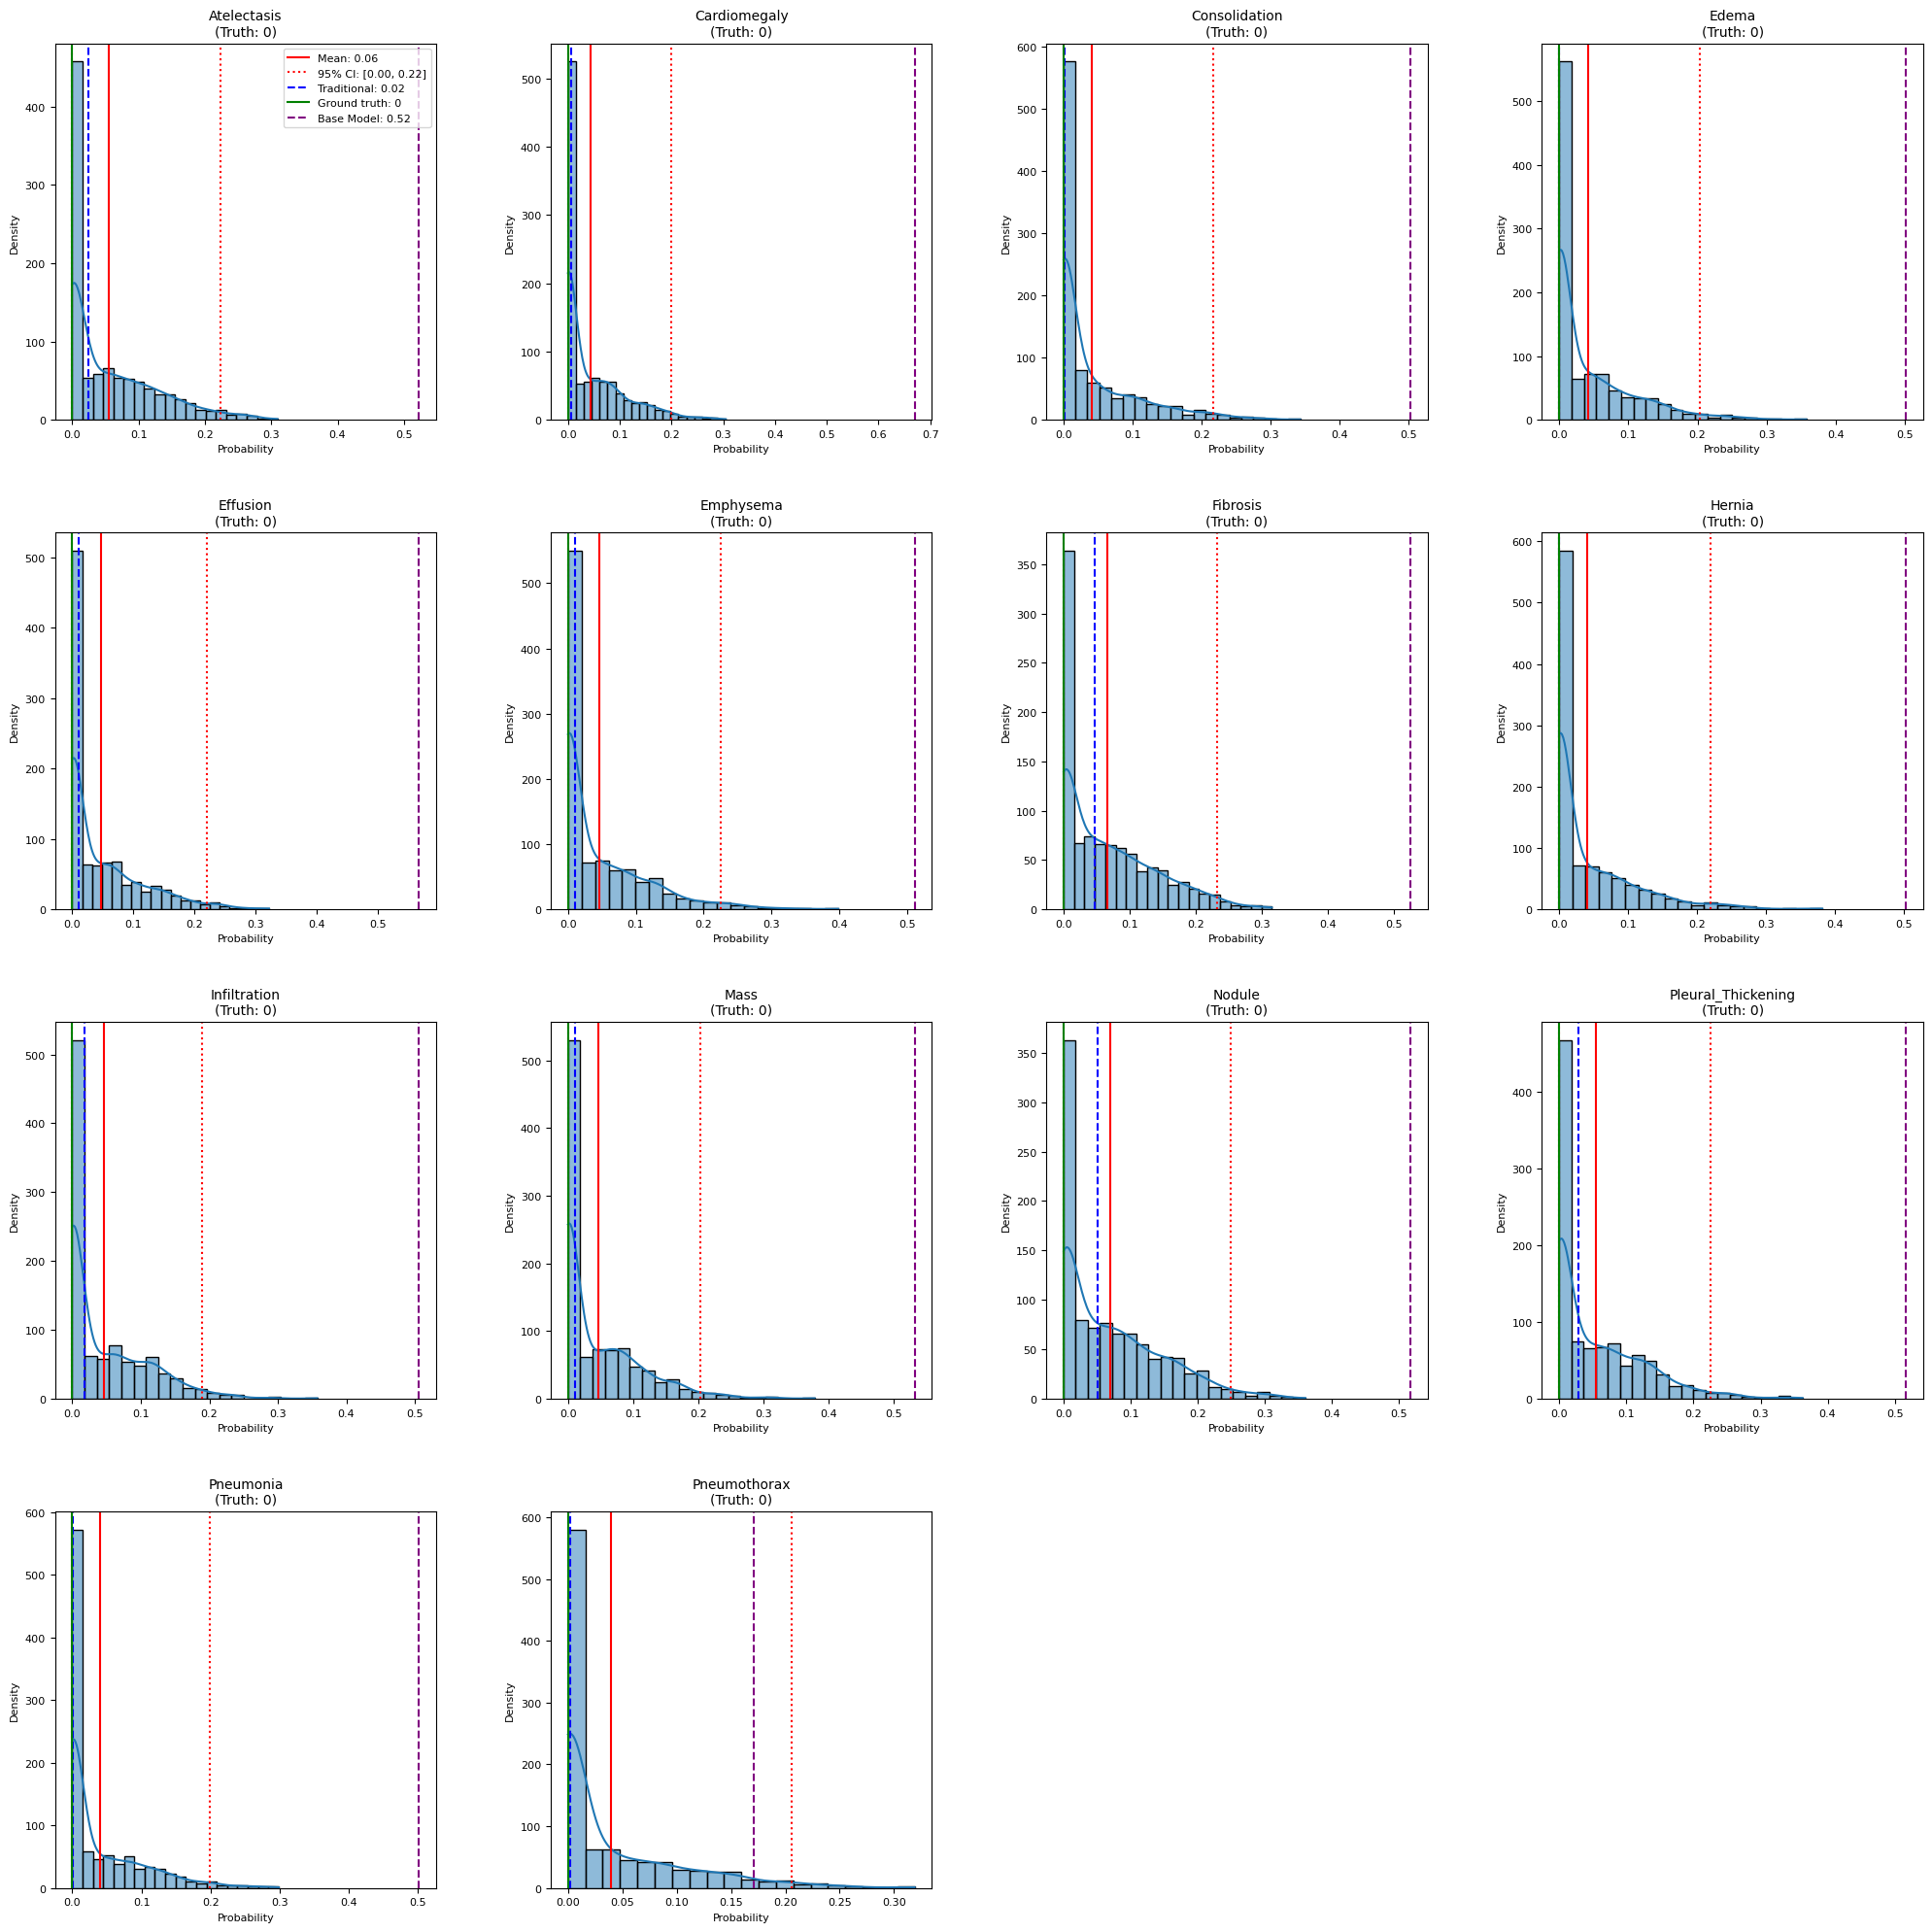


Statistics for Atelectasis:
  Ground truth: 0
  MLE: 0.0238
  MAP: 0.0555
  Median with uncertainty: 0.0282
  95% Credible Interval: [0.0000, 0.2240]
  Standard deviation: 0.0677
  Ground truth within 95% CI: True

Statistics for Cardiomegaly:
  Ground truth: 0
  MLE: 0.0061
  MAP: 0.0442
  Median with uncertainty: 0.0098
  95% Credible Interval: [0.0000, 0.2001]
  Standard deviation: 0.0606
  Ground truth within 95% CI: True

Statistics for Consolidation:
  Ground truth: 0
  MLE: 0.0010
  MAP: 0.0405
  Median with uncertainty: 0.0000
  95% Credible Interval: [0.0000, 0.2170]
  Standard deviation: 0.0622
  Ground truth within 95% CI: True

Statistics for Edema:
  Ground truth: 0
  MLE: 0.0000
  MAP: 0.0411
  Median with uncertainty: 0.0026
  95% Credible Interval: [0.0000, 0.2036]
  Standard deviation: 0.0604
  Ground truth within 95% CI: True

Statistics for Effusion:
  Ground truth: 0
  MLE: 0.0105
  MAP: 0.0466
  Median with uncertainty: 0.0131
  95% Credible Interval: [0.0000, 0.2

In [7]:
results_df = simplified_inference_test(
    model=bayes_net,
    param_samples=param_samples,
    data=data,
    feature_cols=feature_cols,
    pathology_cols=pathology_cols,
    base_model_pred=preds[0],
    idx=0,
    n_samples=1000,
    n_test_samples=3
)


Processing sample 1 with features: {'f0': 4, 'f1': 3, 'f2': 4, 'f3': 3, 'f4': 2, 'f5': 3, 'f6': 3, 'f7': 2, 'f8': 3, 'f9': 2, 'f10': 2, 'f11': 3, 'f12': 4, 'f13': 2, 'f14': 3, 'f15': 2, 'f16': 3, 'f17': 3, 'f18': 4, 'f19': 3, 'f20': 2, 'f21': 3, 'f22': 3, 'f23': 3, 'f24': 4}
Ground truth: {'Atelectasis': 0, 'Cardiomegaly': 0, 'Consolidation': 0, 'Edema': 0, 'Effusion': 0, 'Emphysema': 0, 'Fibrosis': 0, 'Hernia': 0, 'Infiltration': 0, 'Mass': 0, 'Nodule': 0, 'Pleural_Thickening': 0, 'Pneumonia': 0, 'Pneumothorax': 0}
Traditional inference results:
  Atelectasis: 0.0257 (Ground truth: 0)
  Cardiomegaly: 0.0072 (Ground truth: 0)
  Consolidation: 0.0000 (Ground truth: 0)
  Edema: 0.0000 (Ground truth: 0)
  Effusion: 0.0009 (Ground truth: 0)
  Emphysema: 0.0000 (Ground truth: 0)
  Fibrosis: 0.0012 (Ground truth: 0)
  Hernia: 0.0000 (Ground truth: 0)
  Infiltration: 0.0930 (Ground truth: 0)
  Mass: 0.0036 (Ground truth: 0)
  Nodule: 0.0159 (Ground truth: 0)
  Pleural_Thickening: 0.0029 (Gro

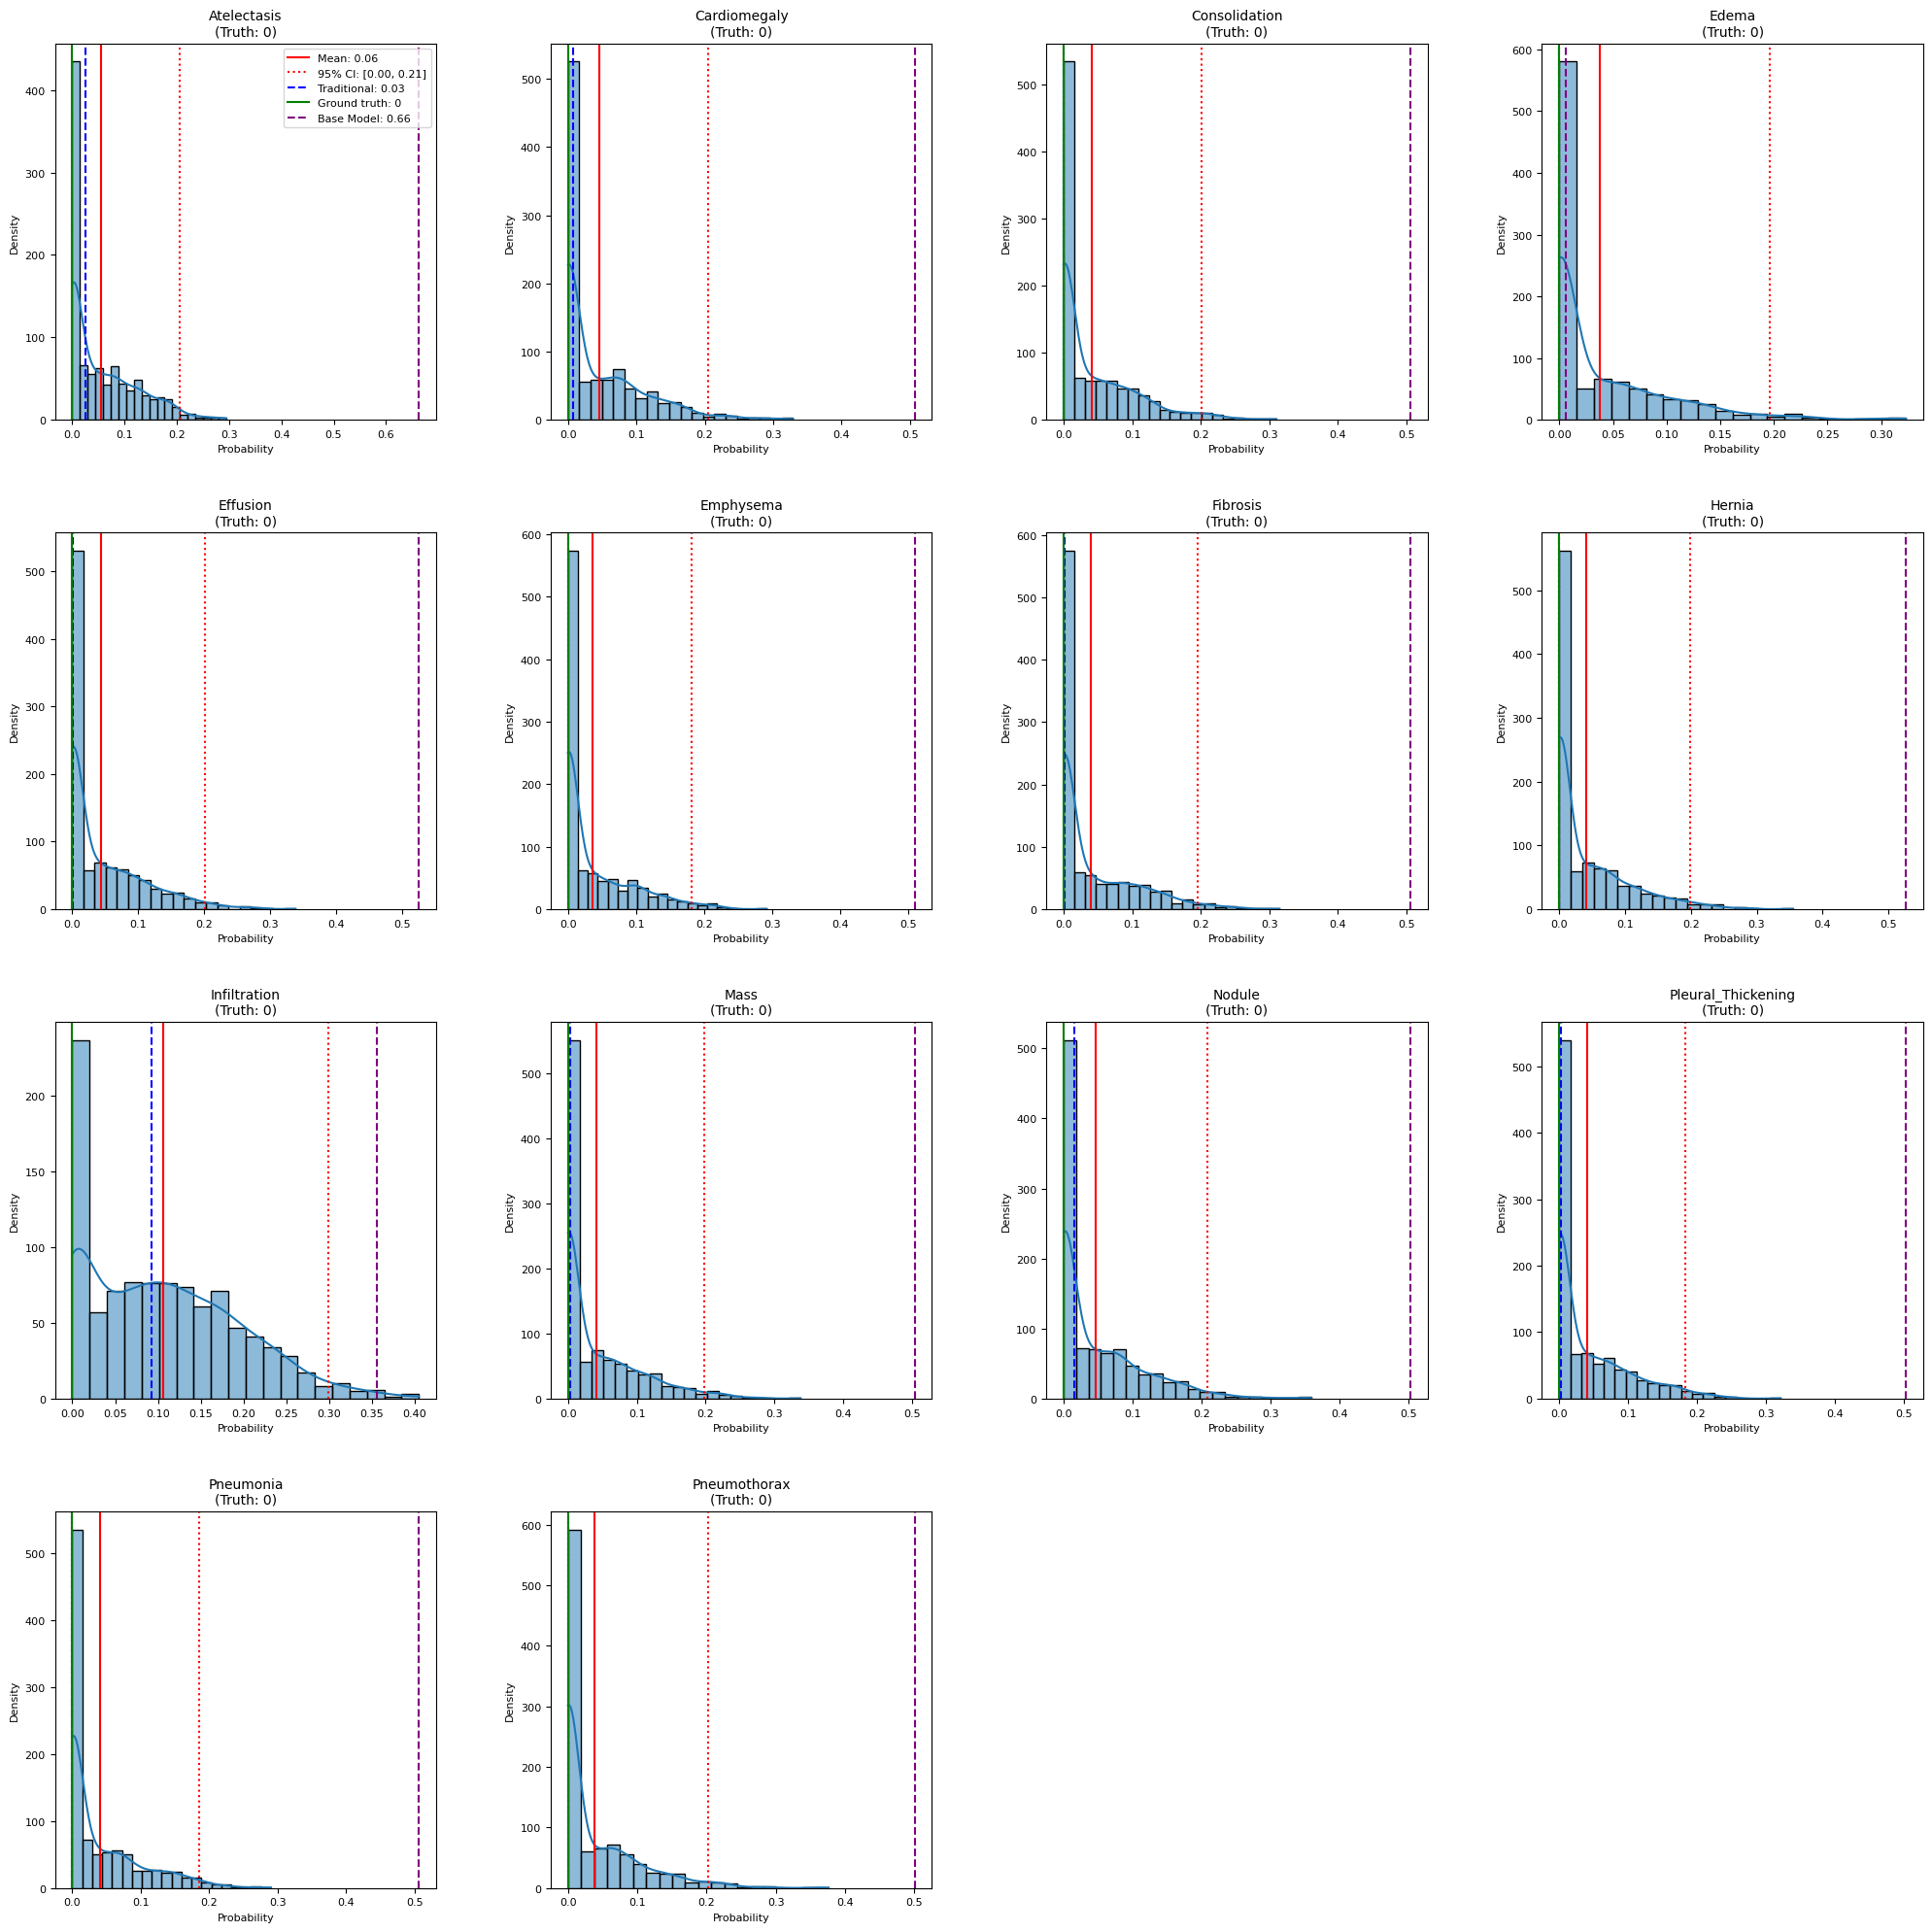


Statistics for Atelectasis:
  Ground truth: 0
  MLE: 0.0257
  MAP: 0.0555
  Median with uncertainty: 0.0292
  95% Credible Interval: [0.0000, 0.2055]
  Standard deviation: 0.0655
  Ground truth within 95% CI: True

Statistics for Cardiomegaly:
  Ground truth: 0
  MLE: 0.0072
  MAP: 0.0454
  Median with uncertainty: 0.0071
  95% Credible Interval: [0.0000, 0.2050]
  Standard deviation: 0.0621
  Ground truth within 95% CI: True

Statistics for Consolidation:
  Ground truth: 0
  MLE: 0.0000
  MAP: 0.0414
  Median with uncertainty: 0.0078
  95% Credible Interval: [0.0000, 0.2010]
  Standard deviation: 0.0577
  Ground truth within 95% CI: True

Statistics for Edema:
  Ground truth: 0
  MLE: 0.0000
  MAP: 0.0376
  Median with uncertainty: 0.0000
  95% Credible Interval: [0.0000, 0.1959]
  Standard deviation: 0.0575
  Ground truth within 95% CI: True

Statistics for Effusion:
  Ground truth: 0
  MLE: 0.0009
  MAP: 0.0442
  Median with uncertainty: 0.0088
  95% Credible Interval: [0.0000, 0.2

In [8]:
results_df = simplified_inference_test(
    model=bayes_net,
    param_samples=param_samples,
    data=data,
    feature_cols=feature_cols,
    pathology_cols=pathology_cols,
    base_model_pred=preds[1],
    idx=1,
    n_samples=1000,
    n_test_samples=3
)


Processing sample 2 with features: {'f0': 4, 'f1': 4, 'f2': 4, 'f3': 4, 'f4': 2, 'f5': 3, 'f6': 3, 'f7': 2, 'f8': 4, 'f9': 3, 'f10': 2, 'f11': 3, 'f12': 4, 'f13': 2, 'f14': 4, 'f15': 2, 'f16': 4, 'f17': 2, 'f18': 3, 'f19': 3, 'f20': 2, 'f21': 3, 'f22': 3, 'f23': 3, 'f24': 3}
Ground truth: {'Atelectasis': 1, 'Cardiomegaly': 0, 'Consolidation': 0, 'Edema': 0, 'Effusion': 0, 'Emphysema': 0, 'Fibrosis': 0, 'Hernia': 0, 'Infiltration': 0, 'Mass': 0, 'Nodule': 0, 'Pleural_Thickening': 0, 'Pneumonia': 0, 'Pneumothorax': 0}
Traditional inference results:
  Atelectasis: 0.0401 (Ground truth: 1)
  Cardiomegaly: 0.0096 (Ground truth: 0)
  Consolidation: 0.0000 (Ground truth: 0)
  Edema: 0.0000 (Ground truth: 0)
  Effusion: 0.0007 (Ground truth: 0)
  Emphysema: 0.0001 (Ground truth: 0)
  Fibrosis: 0.0033 (Ground truth: 0)
  Hernia: 0.0000 (Ground truth: 0)
  Infiltration: 0.0847 (Ground truth: 0)
  Mass: 0.0011 (Ground truth: 0)
  Nodule: 0.0155 (Ground truth: 0)
  Pleural_Thickening: 0.0022 (Gro

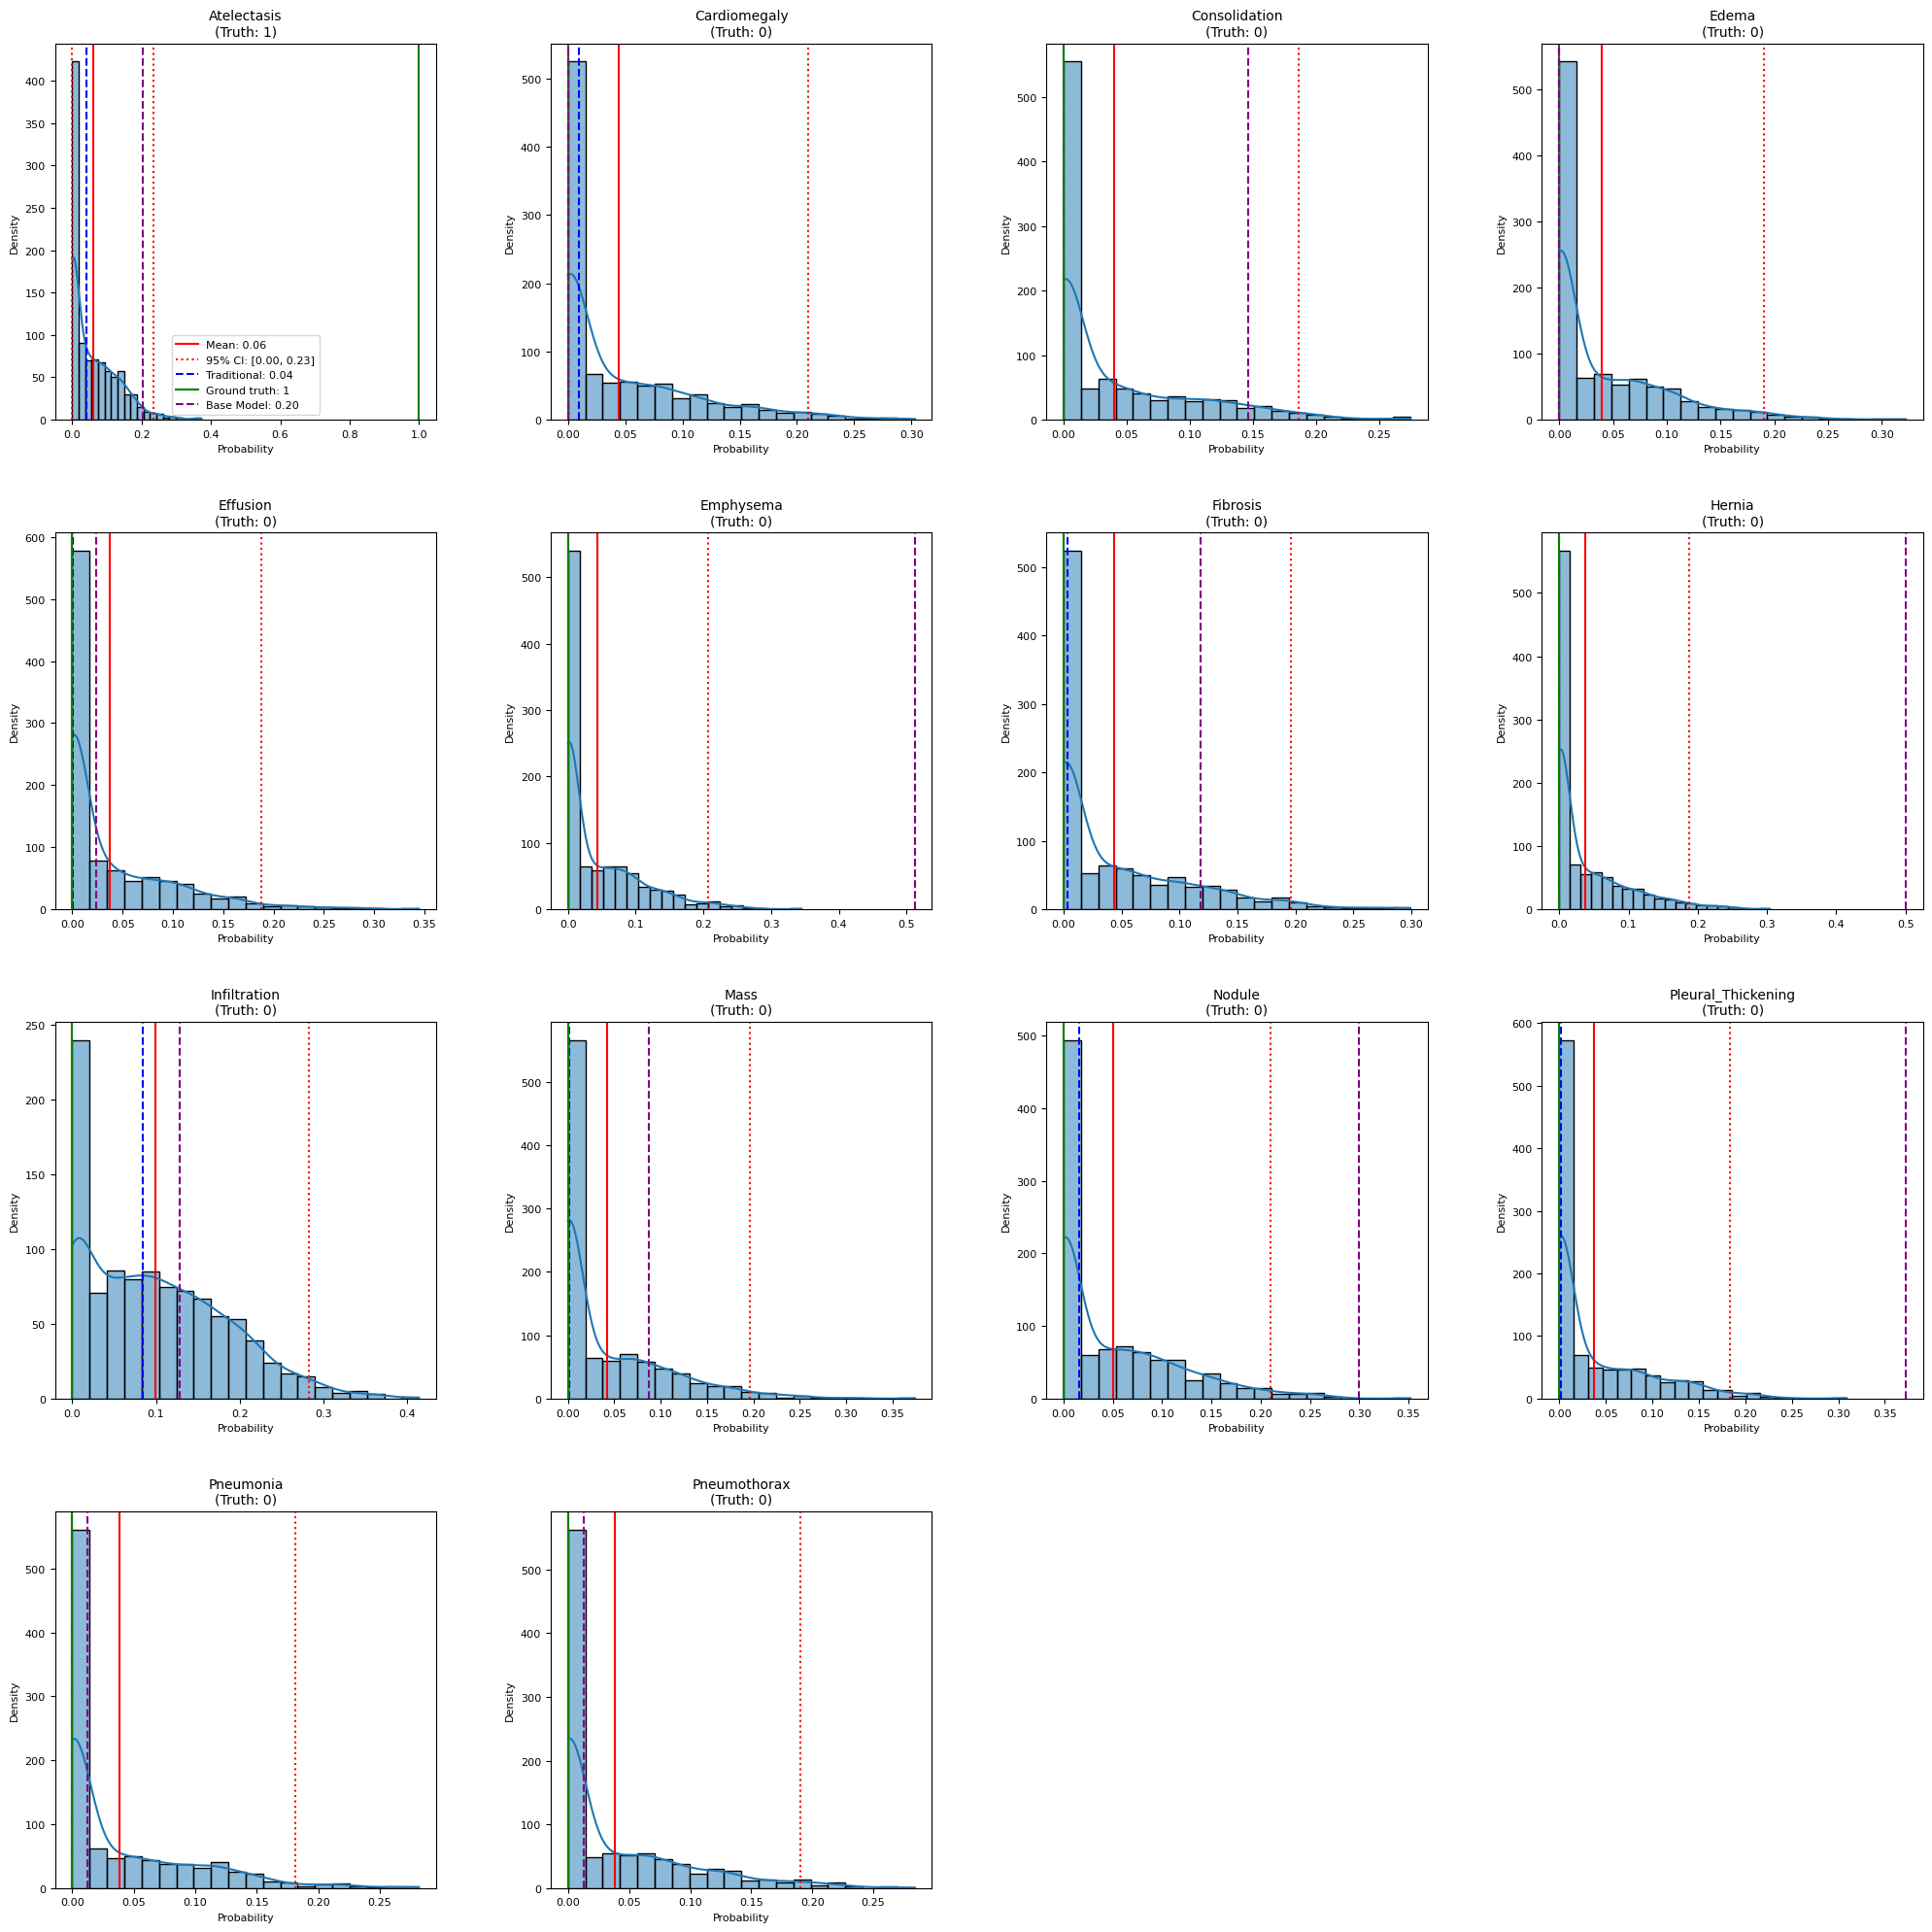


Statistics for Atelectasis:
  Ground truth: 1
  MLE: 0.0401
  MAP: 0.0592
  Median with uncertainty: 0.0346
  95% Credible Interval: [0.0000, 0.2340]
  Standard deviation: 0.0692
  Ground truth within 95% CI: False

Statistics for Cardiomegaly:
  Ground truth: 0
  MLE: 0.0096
  MAP: 0.0443
  Median with uncertainty: 0.0091
  95% Credible Interval: [0.0000, 0.2101]
  Standard deviation: 0.0615
  Ground truth within 95% CI: True

Statistics for Consolidation:
  Ground truth: 0
  MLE: 0.0000
  MAP: 0.0398
  Median with uncertainty: 0.0007
  95% Credible Interval: [0.0000, 0.1866]
  Standard deviation: 0.0573
  Ground truth within 95% CI: True

Statistics for Edema:
  Ground truth: 0
  MLE: 0.0000
  MAP: 0.0395
  Median with uncertainty: 0.0038
  95% Credible Interval: [0.0000, 0.1907]
  Standard deviation: 0.0557
  Ground truth within 95% CI: True

Statistics for Effusion:
  Ground truth: 0
  MLE: 0.0007
  MAP: 0.0376
  Median with uncertainty: 0.0000
  95% Credible Interval: [0.0000, 0.

In [9]:
results_df = simplified_inference_test(
    model=bayes_net,
    param_samples=param_samples,
    data=data,
    feature_cols=feature_cols,
    pathology_cols=pathology_cols,
    base_model_pred=preds[2],
    idx=2,
    n_samples=1000,
    n_test_samples=3
)


Processing sample 3 with features: {'f0': 4, 'f1': 4, 'f2': 4, 'f3': 5, 'f4': 4, 'f5': 3, 'f6': 3, 'f7': 3, 'f8': 3, 'f9': 4, 'f10': 3, 'f11': 4, 'f12': 2, 'f13': 3, 'f14': 4, 'f15': 3, 'f16': 4, 'f17': 3, 'f18': 3, 'f19': 3, 'f20': 1, 'f21': 3, 'f22': 3, 'f23': 1, 'f24': 4}
Ground truth: {'Atelectasis': 0, 'Cardiomegaly': 0, 'Consolidation': 0, 'Edema': 0, 'Effusion': 0, 'Emphysema': 0, 'Fibrosis': 0, 'Hernia': 0, 'Infiltration': 1, 'Mass': 0, 'Nodule': 0, 'Pleural_Thickening': 0, 'Pneumonia': 0, 'Pneumothorax': 0}
Traditional inference results:
  Atelectasis: 0.2013 (Ground truth: 0)
  Cardiomegaly: 0.0489 (Ground truth: 0)
  Consolidation: 0.1068 (Ground truth: 0)
  Edema: 0.0000 (Ground truth: 0)
  Effusion: 0.4550 (Ground truth: 0)
  Emphysema: 0.0085 (Ground truth: 0)
  Fibrosis: 0.0584 (Ground truth: 0)
  Hernia: 0.0079 (Ground truth: 0)
  Infiltration: 0.2250 (Ground truth: 1)
  Mass: 0.0478 (Ground truth: 0)
  Nodule: 0.1263 (Ground truth: 0)
  Pleural_Thickening: 0.0777 (Gro

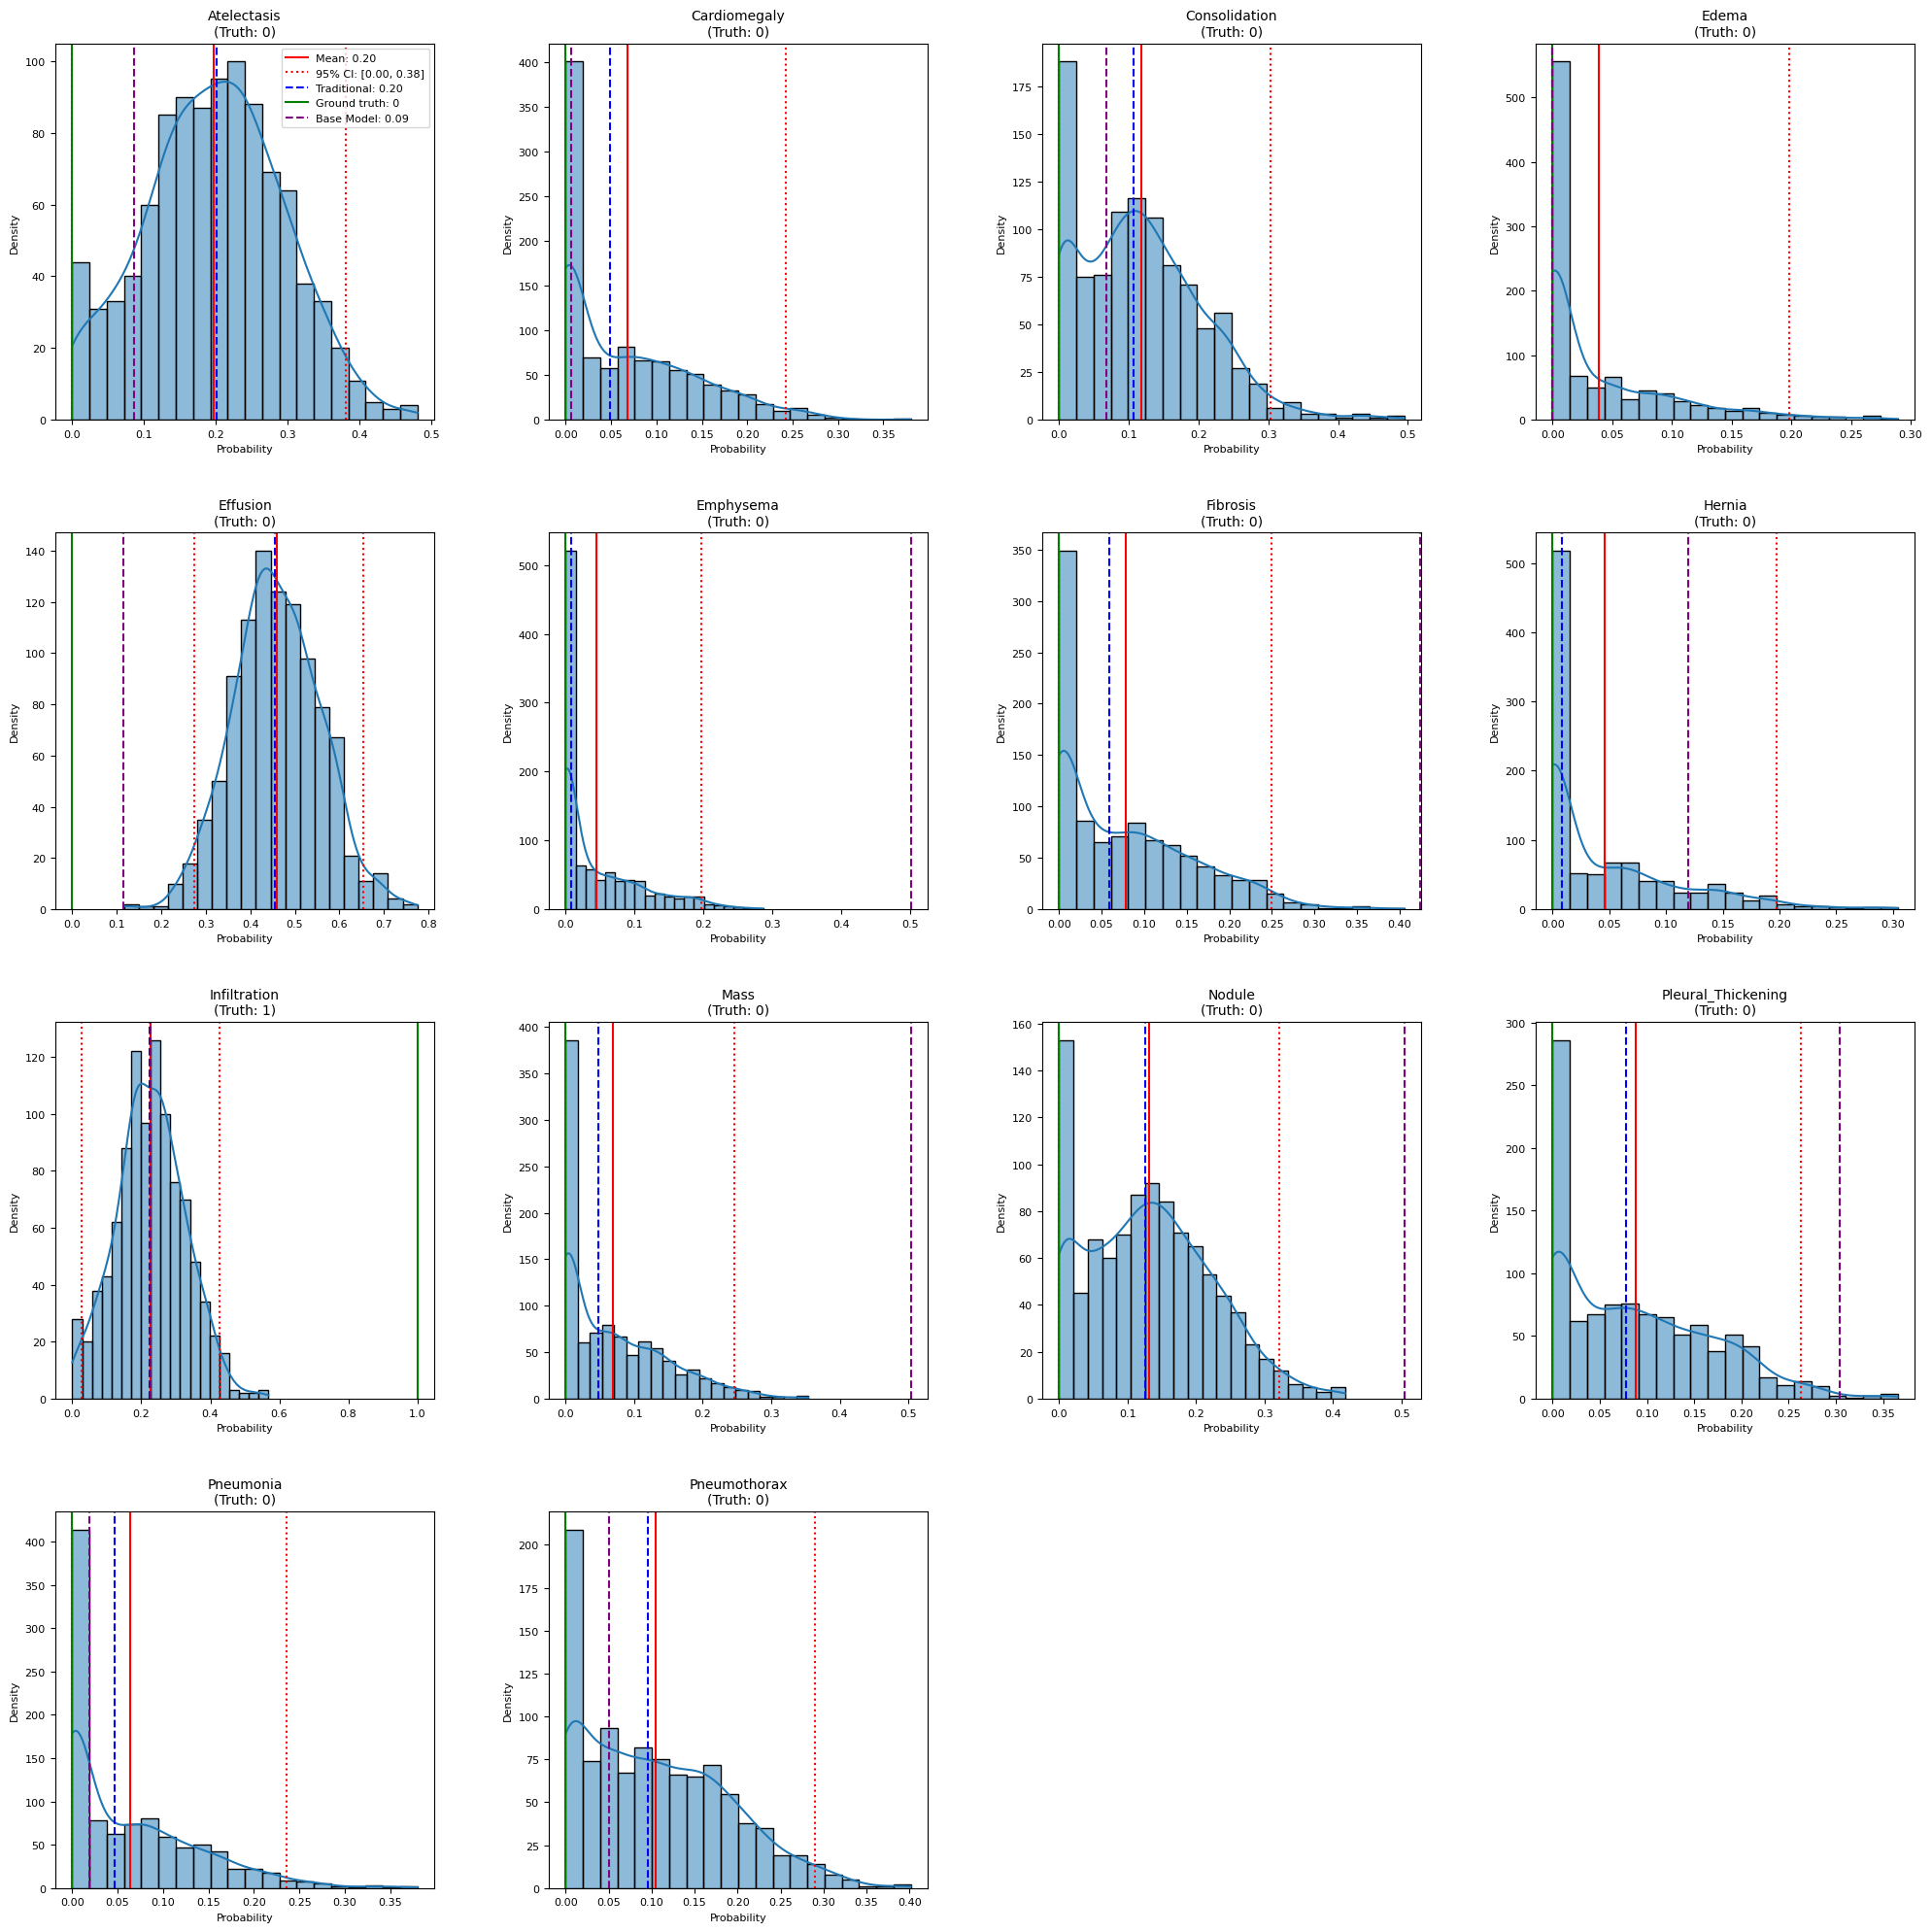


Statistics for Atelectasis:
  Ground truth: 0
  MLE: 0.2013
  MAP: 0.1976
  Median with uncertainty: 0.1985
  95% Credible Interval: [0.0000, 0.3810]
  Standard deviation: 0.0959
  Ground truth within 95% CI: True

Statistics for Cardiomegaly:
  Ground truth: 0
  MLE: 0.0489
  MAP: 0.0680
  Median with uncertainty: 0.0464
  95% Credible Interval: [0.0000, 0.2425]
  Standard deviation: 0.0734
  Ground truth within 95% CI: True

Statistics for Consolidation:
  Ground truth: 0
  MLE: 0.1068
  MAP: 0.1172
  Median with uncertainty: 0.1103
  95% Credible Interval: [0.0000, 0.3033]
  Standard deviation: 0.0882
  Ground truth within 95% CI: True

Statistics for Edema:
  Ground truth: 0
  MLE: 0.0000
  MAP: 0.0386
  Median with uncertainty: 0.0021
  95% Credible Interval: [0.0000, 0.1980]
  Standard deviation: 0.0571
  Ground truth within 95% CI: True

Statistics for Effusion:
  Ground truth: 0
  MLE: 0.4550
  MAP: 0.4592
  Median with uncertainty: 0.4553
  95% Credible Interval: [0.2733, 0.6

In [10]:
results_df = simplified_inference_test(
    model=bayes_net,
    param_samples=param_samples,
    data=data,
    feature_cols=feature_cols,
    pathology_cols=pathology_cols,
    base_model_pred=preds[3],
    idx=3,
    n_samples=1000,
    n_test_samples=3
)

 ## Visualize the Bayes Net

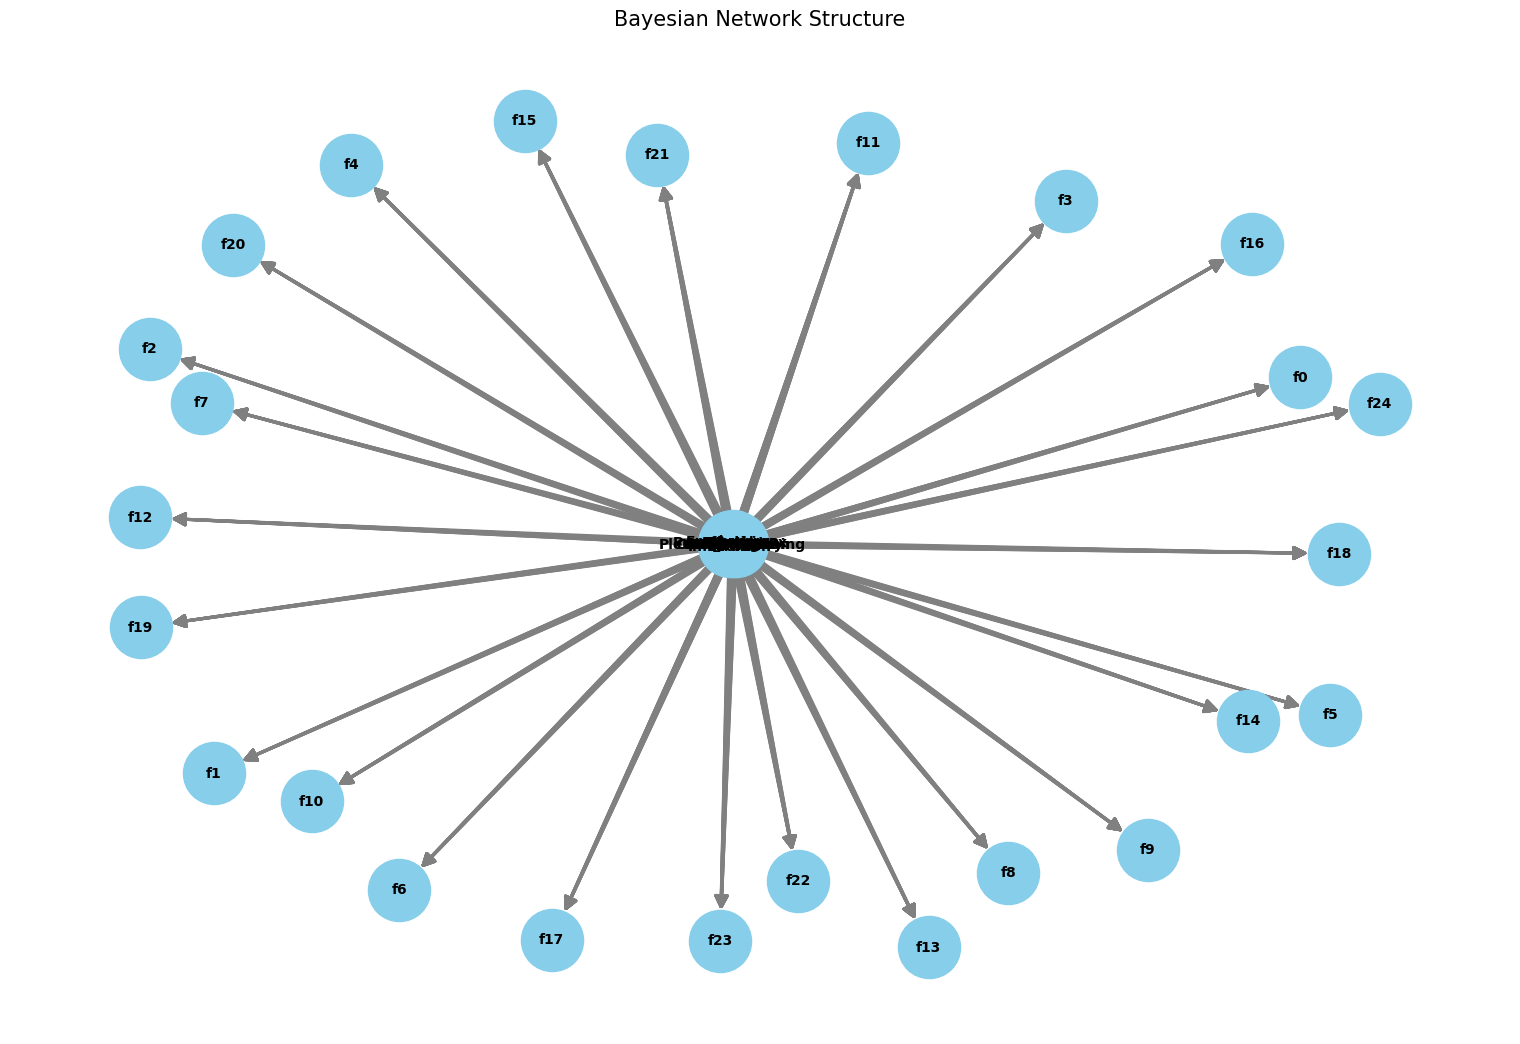

In [11]:
# Import the required libraries
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph from your Bayesian network
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(bayes_net.nodes())

# Add edges
G.add_edges_from(bayes_net.edges())

# Draw the graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42)  # For reproducibility
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", 
        font_size=10, font_weight="bold", arrowsize=20, 
        edge_color="gray", width=2)

plt.title("Bayesian Network Structure", fontsize=15)
plt.tight_layout()
plt.show()

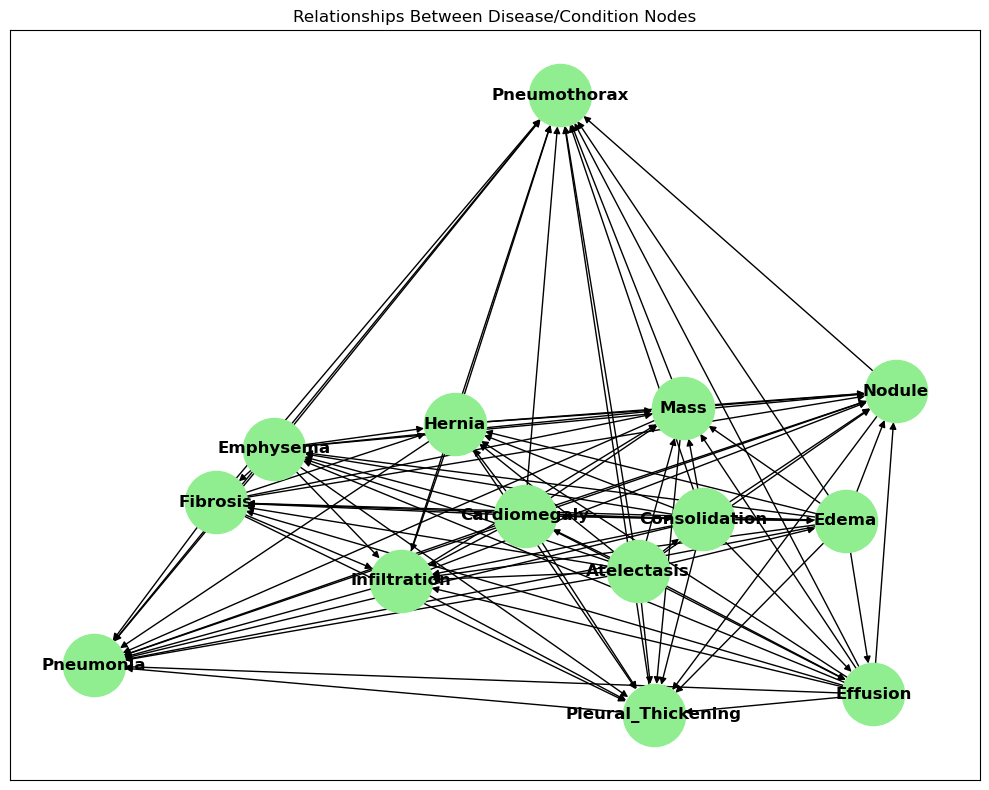

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Assuming bayes_net is your Bayesian network
G = nx.DiGraph()
G.add_nodes_from(bayes_net.nodes())
G.add_edges_from(bayes_net.edges())

# Identify disease/condition nodes vs feature nodes
disease_nodes = [n for n in G.nodes() if not n.startswith('f')]
feature_nodes = [n for n in G.nodes() if n.startswith('f')]

# Option 1: Show just the disease/condition nodes and their relationships
disease_graph = G.subgraph(disease_nodes)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(disease_graph, seed=42)
nx.draw_networkx(disease_graph, pos, 
                node_color='lightgreen',
                node_size=2000,
                font_size=12,
                font_weight='bold')
plt.title("Relationships Between Disease/Condition Nodes")
plt.tight_layout()
plt.show()

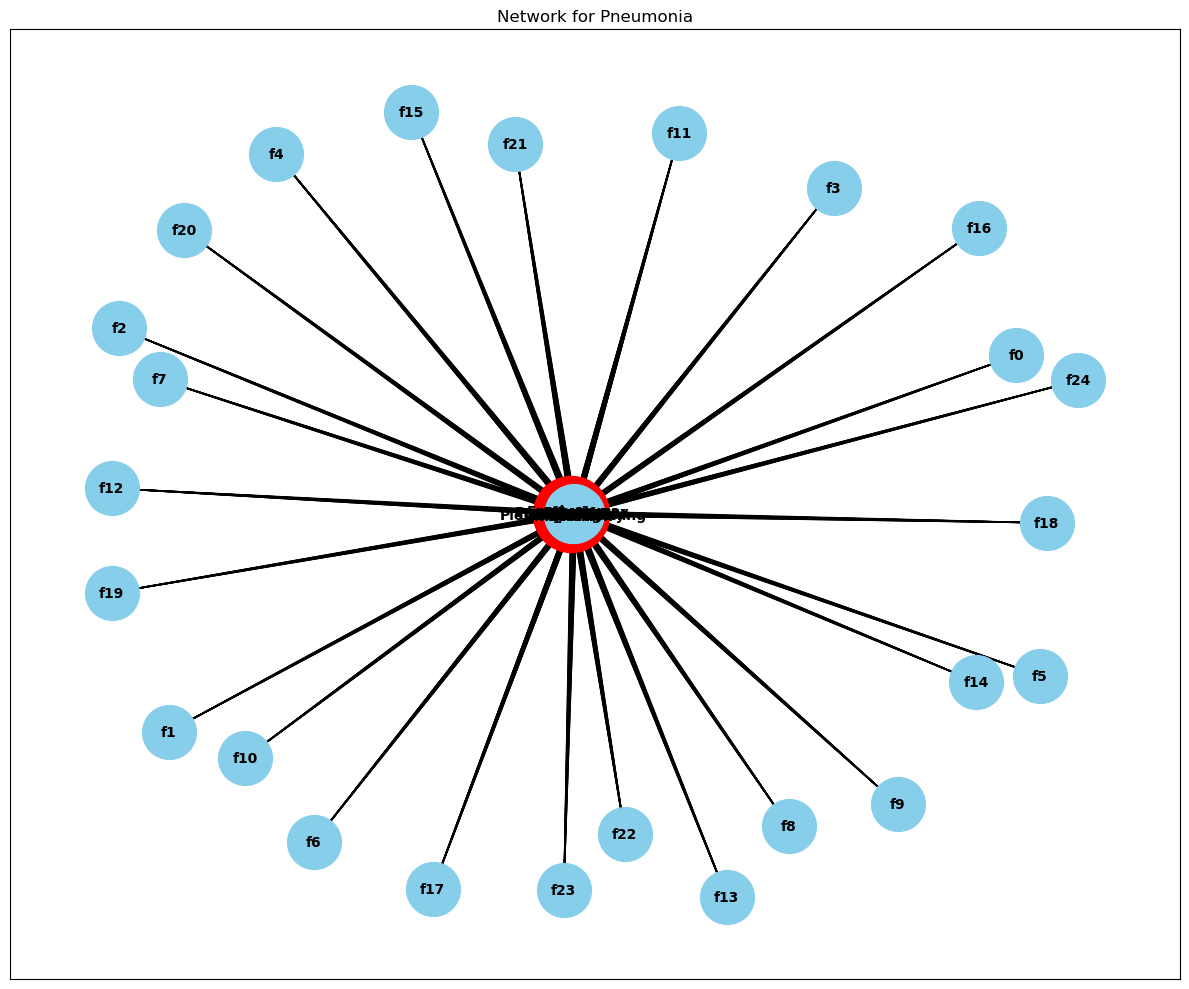

In [13]:
disease_of_interest = "Pneumonia"  # Change to any disease node
neighbors = list(G.predecessors(disease_of_interest)) + list(G.successors(disease_of_interest))
relevant_nodes = [disease_of_interest] + neighbors

subgraph = G.subgraph(relevant_nodes)
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(subgraph, seed=42)

nx.draw_networkx_nodes(subgraph, pos,
                      nodelist=[disease_of_interest],
                      node_color='red',
                      node_size=3000)
nx.draw_networkx_nodes(subgraph, pos,
                      nodelist=[n for n in subgraph.nodes() if n != disease_of_interest],
                      node_color='skyblue',
                      node_size=1500)
nx.draw_networkx_edges(subgraph, pos, arrows=True)
nx.draw_networkx_labels(subgraph, pos, font_size=10, font_weight='bold')

plt.title(f"Network for {disease_of_interest}")
plt.tight_layout()
plt.show()